In [2]:
import SimulatorUtils
import ModifiedNCP_PRIORxbblocks
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import numpy as np
import numpy.ma as ma
import math
from scipy import optimize as opt
from scipy import special as spec
from scipy.optimize import curve_fit


#==================================================================================================
#==========================PLEASE ENTER THE WANTED PARAMETERS======================================
#==================================================================================================
XVP = False              #Whether or not the user wants to simulate XVP flares
exposure = 50000.       #Exposure in seconds    
alpha = 1.              #Pile-up grade migration parameter 
flare_times = np.array([14603.,40000.])   #Center times of flares
flare_duras = np.array([2109.,5641.])     #Durations of flares
flare_flus = np.array([3.74,101.1])*1000. #Fluence of flares (2-10 keV, Unpiled, quiescence-subtracted, units of
                                          #10^37 erg/s)
Q_cr_med = 0.0063       #Quiescence median count rate (ct/s) (a random Poisson rate around this value will 
                        #be drawn)
#==================================================================================================
#=========================THE FOLLOWING PARAMETERS SHOULD BE FINE==================================
#==================================================================================================
cr_size = 10000         #These parameters are just to create the arrays of count rates
min_cr = 1e-4           #used for pile-up calibration. Default values are good
max_cr = 3.
duratosig = 4.          #Number of sigmas assumed to be detected for Gaussian flares by Bayesian Blocks
flare_sim_sig = flare_duras/duratosig
mcrtoA = 1.67           #Coresponding factor between the mean count rate and the amplitude of the Gaussian flare
amplitude_criteria = 3  #Number of error bars above a block's cr needs to be from quiescence to be considered a flare
XVPL2Cr = 0.0077          #The L2Cr paramters are the conversion factors to change flare unabsorbed 2-10keV (units
L2Cr = 0.013              #of 10^34 erg/s) to unpiled and quiescence subtracted 2-8 keV count rates (ct/s).
extrab4 = 32000.        #Extra time (s) before and after the exposure to allow edge flares
extraafter = 32000.

#These two parameters are only needed for XVP simulations
z2f = 1.6               #Flare 0th/1st order counts (quiescence+pile-up corrected)
Q_ratio = 0.44          #Quiescence 0th/1st order counts


if XVP:
    frame_time = 3.14     #Time of each frame in seconds
else:
    frame_time = 0.44

    
#Array needed for pile-up calibration. Represents the incident count rates
incident_cr = np.linspace(min_cr, max_cr,cr_size)

#Observed cr after an incident cr is piled-up. This incident cr therefore contains 0th order cts from both 
#flare and Quiescence in the case of XVP flares.
observed_cr = np.zeros(cr_size)
for i in range(cr_size):
    observed_cr[i] = SimulatorUtils.getratepu(incident_cr[i], frame_time, alpha = alpha)


#Bayesion Blocks (BB) prior calibration
BB_data = np.loadtxt('2ndTry-ncp_prior_p0_005_diffCr.txt')
N=BB_data[:,0]
ncp_prior_p0_arr = BB_data[:,1:]
popt, pcov = opt.curve_fit(SimulatorUtils.AlogN, N,np.mean(ncp_prior_p0_arr, axis=1), sigma=np.std(ncp_prior_p0_arr, axis=1), p0=[0.1,0.3])
pstd = np.sqrt(np.diag(pcov))

In [3]:
#==================================================================================================
#==========================THIS ENTIRE CELL IS FOR XVP PILE-UP CALIBRATION=========================
#==================================================================================================


if XVP:
    f2z = 1./z2f              #1st/0th order flare counts
    
    #Test_cr is an incoming cr (and is therefore made of both flare and quiescence cts)
    test_cr = np.linspace(min_cr,max_cr, cr_size)
    piled_cr = np.zeros(cr_size)
    
    new_ratio = np.zeros(cr_size)
    for i in range(cr_size):
        #For each incoming cr, the detected 0th/1st order ratio will be changed since pile-up ocurs only in 
        #the 0th order. This needs to be accounted for
        piled_cr[i],new_ratio[i] = SimulatorUtils.XVPget_flare_piled(test_cr[i],Q_cr_med,f2z,Q_ratio,frame_time,alpha)
    
    in_piled = np.zeros(cr_size)
    recovered = np.zeros(cr_size)
    
    for i in range(cr_size):
        #Using the calibration computed in the previous loop, we can infer the ratios for a given detected
        #count rate and therefore unpile it properly.
        in_piled[i],_ = SimulatorUtils.XVPget_flare_piled(test_cr[i],Q_cr_med,f2z,Q_ratio,frame_time,alpha)
        recovered[i] = SimulatorUtils.XVPget_flare_unpiled(in_piled[i]+Q_cr_med,Q_cr_med,Q_ratio,new_ratio,piled_cr,incident_cr,observed_cr)

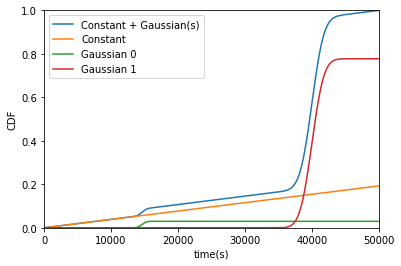

Simulated: 
Quiescence cr: [ 0.00646]
Flare duration: [ 2109.  5641.]
Flare fluence: [   3740.  101100.]
Detected: 
Quiescence cr: [ 0.00750384]
Flare duration: [ 1842.72589672  6326.34024429]
Flare fluence: [   3013.26763391  102117.5502631 ]


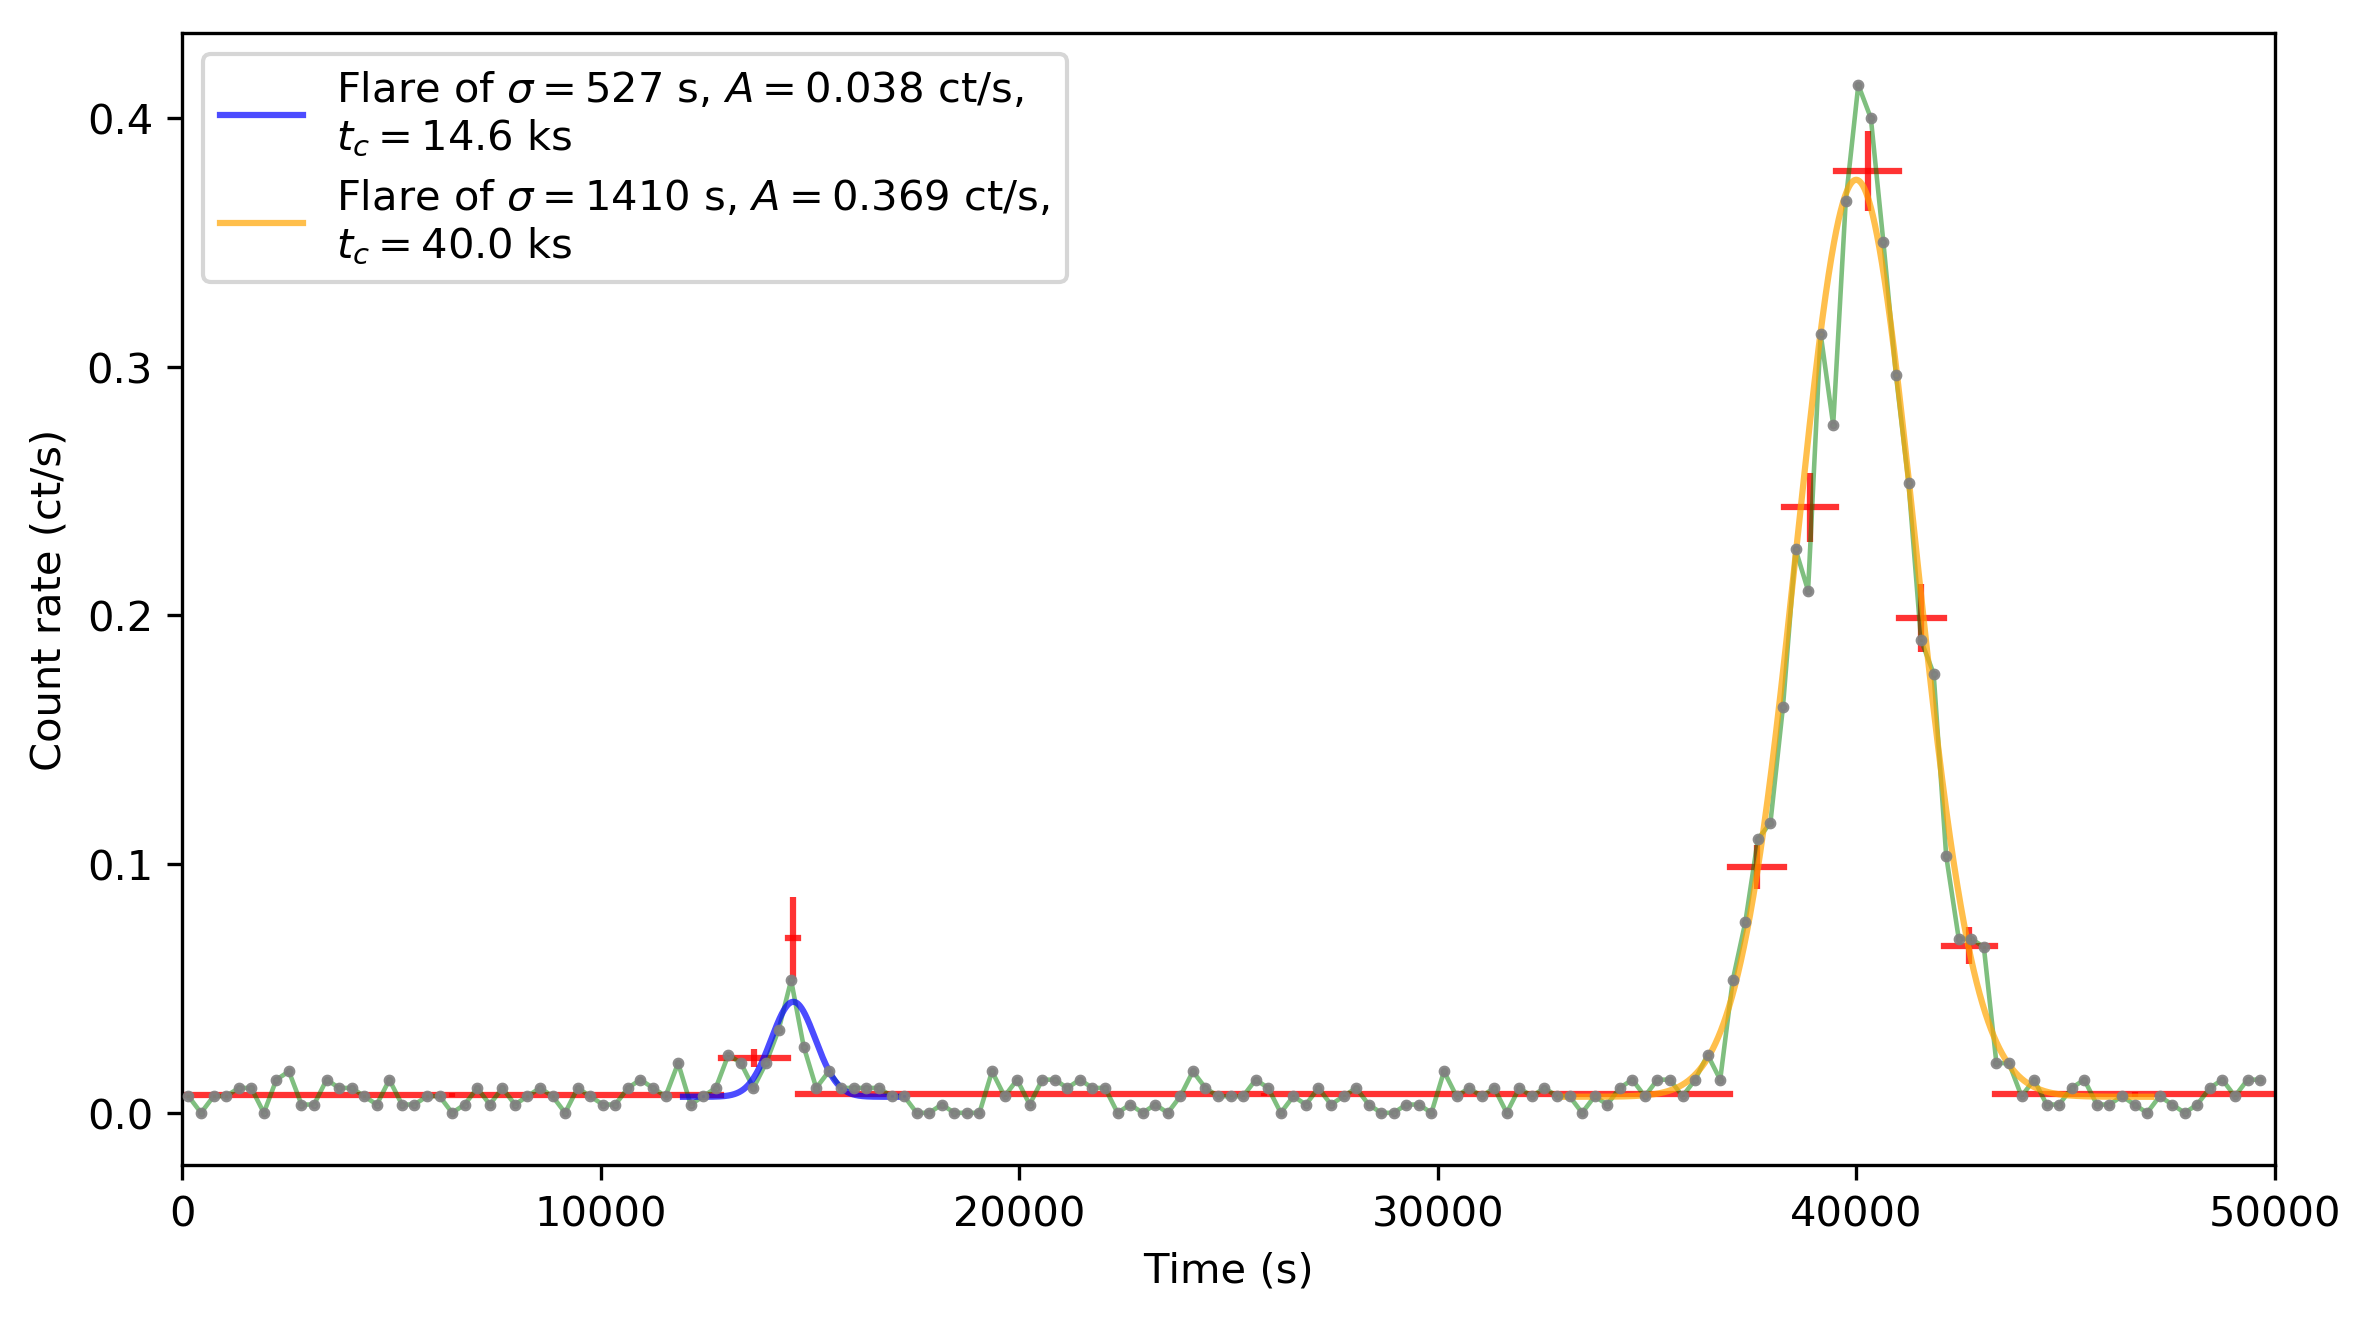

In [4]:
#==================================================================================================
#==========================THIS CELL SIMULATES THE LIGHT CURVE=====================================
#==================================================================================================


#The number of frames depends on the added time on the edges and the frame time
num_frames = int(round((exposure+extrab4+extraafter)/frame_time))
frame_array = np.arange(num_frames)
time_array = frame_array*frame_time                                 #Associate a time to each frame
tp_quiescence = np.random.poisson(Q_cr_med*exposure,1)/(exposure)   #Draw a quiescence count rate        
            
actu_flare_times = flare_times + extrab4     #Place the flares according to the added time
obs_start_t = extrab4
obs_end_t = exposure + extrab4
simu_flare_dura = flare_duras

#Keep only flares that are within 3 sigmas of the observations otherwise they wont be detectable
for j in range(len(flare_duras)):
    bool_keep = ((actu_flare_times[j] + 3*simu_flare_dura[j]/4. > obs_start_t) & 
                (actu_flare_times[j] - 3*simu_flare_dura[j]/4. < obs_end_t))
    if not bool_keep:
        print("The flare at {} was rejected since it is more than 3 sigma away from the simulation.\nIt would not be detectable.".format(flare_times[j]))
        simu_flare_dura[j] = 0

#Recenter the flare times and select only the durations of the flares who made it
actu_flare_times = actu_flare_times[simu_flare_dura>0] - extrab4

simu_flare_dura = simu_flare_dura[simu_flare_dura>0] 

simu_flare_flu = flare_flus  
flare_mcr_piled = np.zeros(len(flare_flus))

#Find the flare piled mean count rates
if XVP:
    for j in range(len(flare_flus)):
        simu_mcr_unpiled = (simu_flare_flu[j]/simu_flare_dura[j])*XVPL2Cr
        flare_mcr_piled[j],_= SimulatorUtils.XVPget_flare_piled(simu_mcr_unpiled,tp_quiescence,f2z,Q_ratio,
                                         frame_time,alpha)
else:
    for j in range(len(flare_flus)):
        simu_mcr_unpiled = (simu_flare_flu[j]/simu_flare_dura[j])*L2Cr
        flare_mcr_piled[j] = SimulatorUtils.getratepu(simu_mcr_unpiled+tp_quiescence,frame_time,alpha) - tp_quiescence

        
t_ev, info = SimulatorUtils.flare_gen(exposure, frame_time, actu_flare_times, flare_sim_sig, flare_mcr_piled, 
                       tp_quiescence, popt,pstd, nbootstrap=0, plot=True,alpha=4,mcrtoA=mcrtoA)


bin_array, binned_cr, binned_cr_err = SimulatorUtils.binnyboy(300.,t_ev[-1], t_ev)

ledges = info.ledges
redges = info.redges
counts = info.counts 
widths = info.widths
rates = info.rates

if XVP:
    data, block, LoRate = SimulatorUtils.XVPget_flare_bb_nobsnopcr(ledges, redges, counts, widths, rates,Q_ratio,
                                                            new_ratio,piled_cr,incident_cr,
                                                            observed_cr,amplitude_criteria = amplitude_criteria)
else:
    data, block, LoRate = SimulatorUtils.get_flare_bb_nobsnopcr(ledges, redges, counts, widths, rates,incident_cr,
                                                            observed_cr,amplitude_criteria = amplitude_criteria)

ledges,redges,counts,widths,rates=data[:,0],data[:,1],data[:,2],data[:,3],data[:,4]
    
det_dura = np.array([])
det_fluence = np.array([])

if XVP:
    if block is not None:
        #For each detected flare...
        for j in range(len(block[:,4])):
            det_dura = np.append(det_dura,block[:,3][j])
            det_fluence = np.append(det_fluence, (block[:,4][j]-LoRate[:,0])*block[:,3][j]/XVPL2Cr)
else:
    #If we detected at least 1 flare
    if block is not None:
        #For each detected flare...
        for j in range(len(block[:,4])):
            det_dura = np.append(det_dura,block[:,3][j])
            det_fluence = np.append(det_fluence, 
                                        (block[:,4][j]- LoRate[:,0])*block[:,3][j]/L2Cr)

print('Simulated: ')
print('Quiescence cr: {}'.format(tp_quiescence))
print('Flare duration: {}'.format(flare_duras))
print('Flare fluence: {}'.format(flare_flus))
print('Detected: ')
print('Quiescence cr: {}'.format(LoRate[:,0]))
print('Flare duration: {}'.format(det_dura))
print('Flare fluence: {}'.format(det_fluence))


fig = plt.figure(figsize=(9, 5), dpi=300)

for j in range(len(rates)):
    bend = redges
    bstart = ledges
    bsrstds = np.sqrt(counts)/widths
    wid = width=widths
    
    if j==0:
        plt.plot(np.linspace(ledges[j],redges[j],2), np.ones(2)*rates[j],color='red',alpha =0.8,ls='-')#, label='Bayesian blocks')
        plt.errorbar((ledges[j]+redges[j])/2, rates[j], yerr =bsrstds[j], ls = 'none', alpha = 0.8,color='red')
    else:
        plt.plot(np.linspace(ledges[j],redges[j],2), np.ones(2)*rates[j],color='red',alpha =0.8,ls='-')
        plt.errorbar((ledges[j]+redges[j])/2, rates[j], yerr =bsrstds[j], ls = 'none', alpha = 0.8,color='red')

plt.scatter(bin_array,binned_cr, color='grey', marker="o", s=3.3, alpha=0.9, zorder=3)#, label='300s bins')
plt.plot(bin_array,binned_cr, color='green', lw=1.1, alpha=0.5)



plt.ylabel('Count rate (ct/s)')
plt.xlabel('Time (s)')
plt.xlim([0,exposure])
flare_Amp = mcrtoA*flare_mcr_piled
size = len(flare_sim_sig)
sizet = int((10*np.sort(flare_sim_sig)[-1])/(0.1*frame_time)+1)
tgau = np.zeros(size*sizet).reshape(size,sizet)
for i in range(size):
    tgau[i] = np.linspace(actu_flare_times[i]-5*flare_sim_sig[i],actu_flare_times[i]+5*flare_sim_sig[i],sizet)
for i in range(size):
    if i==0:
        plt.plot(tgau[i], SimulatorUtils.Gau(tgau[i],flare_Amp[i], flare_sim_sig[i], actu_flare_times[i])+
             tp_quiescence*np.ones(len(tgau[i])), '-', color='blue', lw=1.5, alpha=0.7,
             label=r'Flare of $\sigma={:5.0f}$ s, $A={:1.3f}$ ct/s,'.format(
                 flare_sim_sig[i],flare_Amp[i])+'\n' +r'$t_c={:5.1f}$ ks'.format(actu_flare_times[i]/1000.))
    else:
        plt.plot(tgau[i], SimulatorUtils.Gau(tgau[i],flare_Amp[i], flare_sim_sig[i], actu_flare_times[i])+
             tp_quiescence*np.ones(len(tgau[i])), '-', color='orange', lw=1.5, alpha=0.7,
             label=r'Flare of $\sigma={:5.0f}$ s, $A={:1.3f}$ ct/s,'.format(
                 flare_sim_sig[i],flare_Amp[i])+'\n' +r'$t_c={:5.1f}$ ks'.format(actu_flare_times[i]/1000.))

plt.legend()
plt.show()
